In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import numpy as np

In [20]:
df_train = pd.read_csv(r'G:\__ПРЕЗЕНТАЦИИ\3_ML\ДЗ\telcom_churn_train.csv')
df_test = pd.read_csv(r'G:\__ПРЕЗЕНТАЦИИ\3_ML\ДЗ\telcom_churn_test.csv')

In [21]:
obj_col1 = df_train.select_dtypes('object').columns
obj_col2 = df_test.select_dtypes('object').columns

In [22]:
# закодируем категориальные переменные

enc = OneHotEncoder(handle_unknown='ignore', drop='first')

enc_df_train = pd.DataFrame(enc.fit_transform(df_train[obj_col1]).toarray())
df_train = df_train.join(enc_df_train)

enc_df_test = pd.DataFrame(enc.transform(df_test[obj_col2]).toarray())
df_test = df_test.join(enc_df_test)

In [23]:
#удалим категориальные переменные

df_train.drop(obj_col1, axis=1, inplace=True)
df_test.drop(obj_col2, axis=1, inplace=True)

In [24]:
#заменим NA на медианные значения

def impute_NA_with_median(data, NA_col=[]):
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i] = data_copy[i].fillna(data[i].median())
    return data_copy

In [25]:
col_with_NA1 = df_train.columns[df_train.isnull().sum()!=0]
col_with_NA2 = df_test.columns[df_test.isnull().sum()!=0]

In [26]:
df_train = impute_NA_with_median(data=df_train, NA_col = col_with_NA1)
df_test = impute_NA_with_median(data=df_test, NA_col = col_with_NA2)

In [27]:
X_train = df_train.drop(['churn'], axis=1)
X_test = df_test.drop(['churn'], axis=1)
y_train = df_train['churn']
y_test = df_test['churn']

In [28]:
params = {'n_estimators': 100,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

G:\Anaconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.59650	validation_1-auc:0.58361
[1]	validation_0-auc:0.64336	validation_1-auc:0.63529
[2]	validation_0-auc:0.65200	validation_1-auc:0.64699
[3]	validation_0-auc:0.65337	validation_1-auc:0.64788
[4]	validation_0-auc:0.65548	validation_1-auc:0.65018
[5]	validation_0-auc:0.65701	validation_1-auc:0.65118
[6]	validation_0-auc:0.65704	validation_1-auc:0.65132
[7]	validation_0-auc:0.65792	validation_1-auc:0.65196
[8]	validation_0-auc:0.65841	validation_1-auc:0.65221
[9]	validation_0-auc:0.65890	validation_1-auc:0.65283
[10]	validation_0-auc:0.66107	validation_1-auc:0.65391
[11]	validation_0-auc:0.66161	validation_1-auc:0.65440
[12]	validation_0-auc:0.66238	validation_1-auc:0.65582
[13]	validation_0-auc:0.66315	validation_1-auc:0.65627
[14]	validation_0-auc:0.66412	validation_1-auc:0.65720
[15]	validation_0-auc:0.66425	validation_1-auc:0.65735
[16]	validation_0-auc:0.66535	validation_1-auc:0.65865
[17]	validation_0-auc:0.66594	validation_1-auc:0.65899
[18]	validation_0-au

In [29]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

In [32]:
# Подбираем max_depth и min_child_weight

from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5, 8, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 15 candidates, totalling 15 fits
[CV 1/1] END ...max_depth=3, min_child_weight=1;, score=0.662 total time=  26.4s
[CV 1/1] END ...max_depth=3, min_child_weight=3;, score=0.662 total time=  26.2s
[CV 1/1] END ...max_depth=3, min_child_weight=5;, score=0.662 total time=  26.3s
[CV 1/1] END ...max_depth=3, min_child_weight=8;, score=0.662 total time=  26.2s
[CV 1/1] END ..max_depth=3, min_child_weight=10;, score=0.662 total time=  26.1s
[CV 1/1] END ...max_depth=5, min_child_weight=1;, score=0.680 total time=  41.7s
[CV 1/1] END ...max_depth=5, min_child_weight=3;, score=0.680 total time=  41.6s
[CV 1/1] END ...max_depth=5, min_child_weight=5;, score=0.679 total time=  42.6s
[CV 1/1] END ...max_depth=5, min_child_weight=8;, score=0.680 total time=  43.2s
[CV 1/1] END ..max_depth=5, min_child_weight=10;, score=0.680 total time=  41.6s
[CV 1/1] END ...max_depth=7, min_child_weight=1;, score=0.689 total time= 1.0min
[CV 1/1] END ...max_depth=7, min_child_weight=3;

In [33]:
# Подбираем subsample и colsample_bytree

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV 1/1] END colsample_bytree=0.5, subsample=0.5;, score=0.686 total time=  58.1s
[CV 1/1] END colsample_bytree=0.5, subsample=0.6;, score=0.686 total time=  44.7s
[CV 1/1] END colsample_bytree=0.5, subsample=0.7;, score=0.687 total time=  45.8s
[CV 1/1] END colsample_bytree=0.5, subsample=0.8;, score=0.686 total time=  40.6s
[CV 1/1] END colsample_bytree=0.5, subsample=0.9;, score=0.686 total time=  40.0s
[CV 1/1] END colsample_bytree=0.5, subsample=1.0;, score=0.686 total time=  45.1s
[CV 1/1] END colsample_bytree=0.6, subsample=0.5;, score=0.687 total time=  46.5s
[CV 1/1] END colsample_bytree=0.6, subsample=0.6;, score=0.687 total time=  47.0s
[CV 1/1] END colsample_bytree=0.6, subsample=0.7;, score=0.687 total time=  46.9s
[CV 1/1] END colsample_bytree=0.6, subsample=0.8;, score=0.687 total time=  48.6s
[CV 1/1] END colsample_bytree=0.6, subsample=0.9;, score=0.688 total time=  49.4s
[CV 1/1] END colsample_bytree=0.6, su

In [34]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Train:
ROC AUC: 0.7474
Test:
ROC AUC: 0.6892


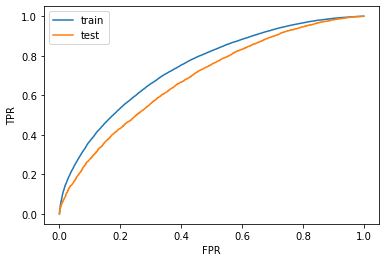

In [35]:
from sklearn.metrics import auc, roc_curve

y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.legend();

In [ ]:
#подставить путь к валидационной выборке
path = 
df_val = pd.read_csv(path)

obj_col3 = df_val.select_dtypes('object').columns
enc_df_val = pd.DataFrame(enc.transform(df_val[obj_col3]).toarray())
df_val = df_val.join(enc_df_val)
df_val.drop(obj_col3, axis=1, inplace=True)

col_with_NA3 = df_val.columns[df_val.isnull().sum()!=0]
df_val = impute_NA_with_median(data=df_val, NA_col = col_with_NA3)

X_val = df_val.drop(['churn'], axis=1)
y_val = df_val['churn']

y_pred_xgb_val = clf_xgb.predict_proba(X_val)[:, 1]

print('Validation:')
calc_auc(y_val, y_pred_xgb_val, 'val')
plt.legend();